[Go back to dashboard](http://ai-master.sh.intel.com:8080)

In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as img
import time
import os
import copy
import requests
from PIL import Image

plt.ion()

In [9]:
def model_prep(model_path):
    model_ft = models.resnet50()
    model_ft.load_state_dict(torch.load('./resnet50-19c8e357.pth'))
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft.load_state_dict(torch.load(model_path))
    model_ft.eval()
    return model_ft

In [10]:
def img_preprocess(img_path):
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    
    img_list = os.listdir(img_path)
    img_list.sort()
    infer_img_list = []
    
    for img_name in img_list[5:-5]:
        tmp_img = Image.open(os.path.join(img_path, img_name))
        img_data = test_transform(tmp_img)
        infer_img_list.append(img_data)

    return infer_img_list
    

In [11]:
def predict(img_path, model, batch_size=10):
    device = torch.device('cpu')
    imgs = img_preprocess(img_path)
    # 4 dimensions: batch_num, channels, width, height
    batch_imgs = torch.Tensor(batch_size, imgs[0].size()[0], imgs[0].size()[1], imgs[0].size()[2])
    predictions = []
    
    for i in range(int(len(imgs) / batch_size)):
        for batch_ind in range(batch_size):
            batch_imgs[batch_ind] = imgs[i * batch_size + batch_ind]
            
        with torch.no_grad():
            batch_imgs = batch_imgs.to(device)
            outputs = model(batch_imgs)
            _, preds = torch.max(outputs.data, 1)
            preds_num = preds.numpy()
            predictions.extend(preds_num.tolist())

    return predictions

In [12]:
def print_acc(predictions):
    ground_true = [0] * 5 + [1] * 5
    corrects = 0
    for index, label in enumerate(ground_true, 0):
        if predictions[index] == label:
            corrects += 1
    print('inference accuracy: {}%'.format((corrects / len(predictions)) * 100))

In [13]:
model = model_prep('./official_model.pt')
predictions = predict('./inference_imgs/', model)
print_acc(predictions)

inference accuracy: 90.0%


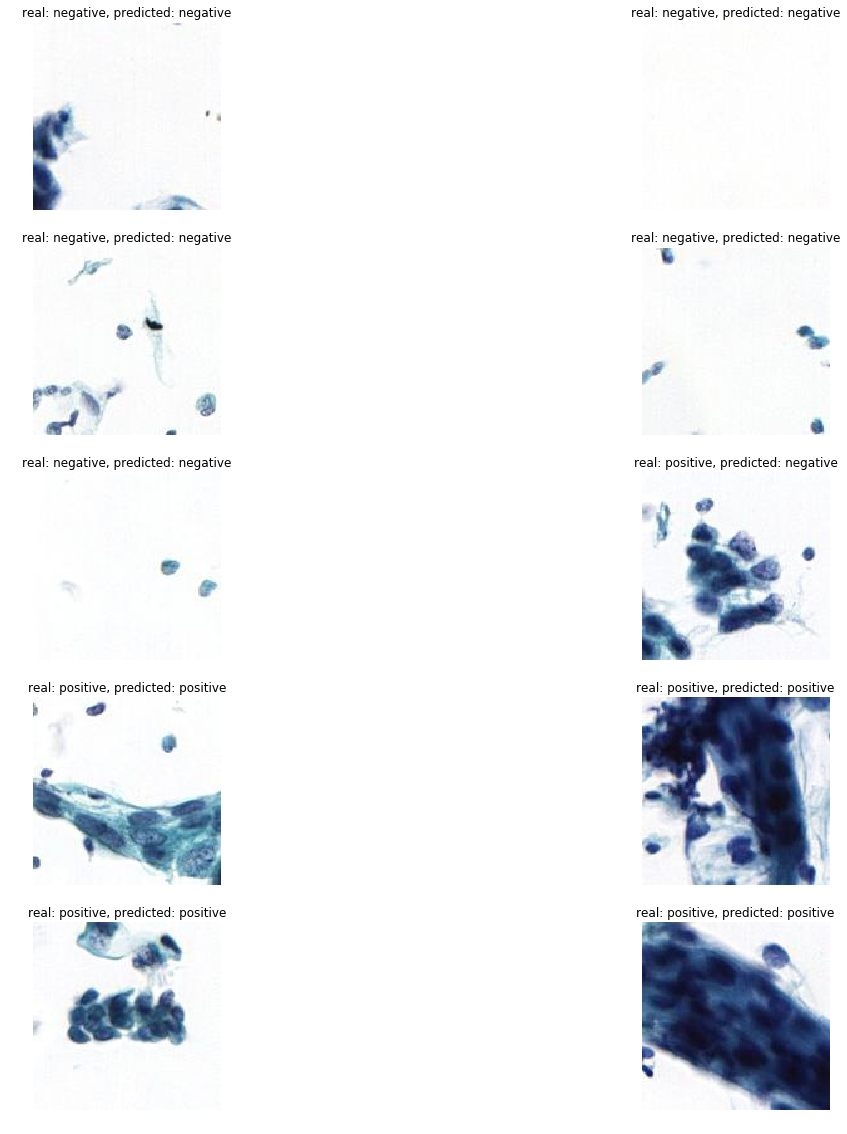

In [14]:
%matplotlib inline

label_dict = {'0': 'negative', '1': 'positive'}
img_name_list = os.listdir('./inference_imgs')
img_name_list.sort()
img_list = [img.imread(os.path.join('./inference_imgs', filename)) for filename in img_name_list[5:-5]]
ground_true = [0] * 5 + [1] * 5
num_of_imgs = 10

fig = plt.figure(figsize=(20, 20))
for i in range(num_of_imgs):
    plt.subplot(5, 2, i+1)
    plt.axis('off')
    plt.title('real: {}, predicted: {}'.format(label_dict[str(ground_true[i])], label_dict[str(predictions[i])]))
    plt.imshow(img_list[i])
